# Code used for composition "Anthropocène"

## Population simulation

In [22]:
import random                  
import math
import numpy as np
from matplotlib import pyplot as plt

Lets first code an class to represent animals and their caracteristics which are
 - Position on a 1D space
 - Health
 - Courage

These parameter will be explained in the following.

In [2]:
class Animal:
    def __init__(self, position = 0, courage = 0, health = True):
        """Position : -1,0,1 (default : 0). courage : 0 (fear), 1 (neutral), 2 (courageous) (default : 0).
        health : bool True for good, False for bad (default : True)."""
        self.position_ = position
        self.courage_ = courage
        self.health_ = health
    
    # Getters
    def getPosition(self):
        return self.position_
    
    def getHealth(self):
        return self.health_
    
     def getCourage(self):
        return self.courage_
    
    # Setters
    def setPosition(self, position):
        self.position_ = position
    
    def setHealth(self, health):
        self.health_ = health
    
    def setCourage(self, courage):
        self.courage_ = courage

## Model theory

The finale model kept for the composition is a discret one : continuous changes weren't audible.

We considere a 1D space with 3 positions which are **Left**, **Middle** and **Right**. All of those positions can host from 0 to all 3 animals. Each animal moves from one position to another (or to the same) one at the time, to chase his prey and flee from its predator. 

If the prey and the predator of one animal are in the same position (L, M or R), there is conflict between the 2 rules **chase his prey** and **flee from its predator**. The behavior of the animal is then determine by its courage. 
- If the animal is fearful, it will fear its predator and stay were it is, or flee if all 3 animals are in the same place. 
- If it is courageous, it will see his prey and attack even if it comes near it predator, or stay if all 3 animals are in the same place. 
- If the animal is neutral, it will randomely be courageous of fearful.

The health parameter was then determined by the position of the animal and of its predator. If an animal is on the same position L, M or R as its predator, then it is in bad health. Else, it is in good health.

Notice that the human action is not disturbing the movements of animals : changes in the behavior of animals were indeed complicated to define and not even audible.

## Structure and proportion of the piece

Here is a plot to visualize the proportions of the piece : the first dot symbolizes the apparition of humans, and the second one symbolize death of the system. 

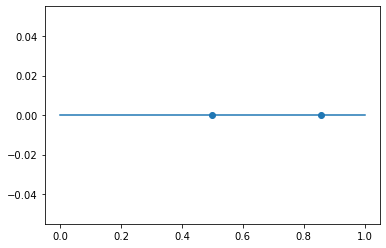

In [4]:
plt.plot([0, 1], [0, 0])
plt.scatter([1/2, 6/7], [0,0])

For a BPM = 60 and 8 beats per bar, 22 bars corresponds to 176s, which is approximately 3 minutes. With those proportions, it would mean around 11 or 12 bars for the first part of natural equilirbium, 3 or 4 bars for the rebirth of nature, and then 6, 7 or 8 bar for the human action.

In the end, 11 bars were used for natural equilibrium, 9 bars for human action, and 5 bars for the rebirth of nature.

## Transcription into music

A chord progression was written so that there was 1 chord per bar (except in the coda and right before the death of nature, were everything is freezed in the same configuration). Each bar contains $N_{beat} = 8$ beats.

The species were moving every $dt=5$ beats, so that the chord changes and the displacement doesn't always happens together.

## Engine

Let's code an engine that applies those rules :

In [13]:
class Engine:
    def __init__(self, animals, Nbars = 22, Nbeats=8, dt=5):
        """animals : vector of 3 Animal. Nbars : number of bars (default 22). 
        Nbeats : number of beats per bar (default 8). dt : number of beat between 2 moves (default 5)."""
        # Conceptual data
        self.animals_ = animals
        # Numerical data
        self.Nbars_ = Nbars
        self.Nbeats_ = Nbeats
        self.dt_ = dt

    
    def step(self, animal, prey, predator):
        """Evolution of the position."""
        # Compute an initiale displacement -1, 0 or +1
        displacement = self.normalize(self.direction(animal, prey) - self.direction(animal, predator))
        # Differentiate the different cases : if displacement = 0, it means that the prey and the predator
        # are in the same position
        if displacement == 0:
            
            # Courageous (attacks anyway) ==========
            if animal.getCourage() == 2:
                displacement = self.direction(animal, prey)
            
            # Neutral (randomely attack, or randomely don't move) =============
            elif (animal.getCourage() == 1):
                if random.choice((True, False)):
                    # Attack
                    displacement = self.direction(animal, prey)
                elif self.direction(animal, predator) == 0:
                    # Flee from its predator
                    if animal.getPosition() == 1:
                        displacement = -1
                    elif animal.getPosition() == 0:
                        displacement = random.choice((1, -1))
                    else:
                        displacement = 1
            
            # Fearful (don't move) =============
            elif (animal.getCourage() == 0) and (self.direction(animal, predator)==0):
                if animal.getPosition() == 1:
                    displacement = -1
                elif animal.getPosition() == 0:
                    displacement = random.choice((1, -1))
                else:
                    displacement = 1
        
        # Apply displacement
        animal.setPosition(animal.getPosition() + displacement)
        return animal
        
    def direction(self, animal, other):
        """Gives the normalize direction to the other animal (+1, 0 or -1)."""
        return self.normalize(self.distance(animal, other))
    
    def distance(self, animal, other):
        """Gives the signed distance to the other animal (-2, -1, 0, +1 or +2)."""
        return other.getPosition() - animal.getPosition()
    
    def normalize(self, displacement):
        """Normalizes the signed distance into direction."""
        if displacement != 0:
            displacement /= abs(displacement)
        return displacement
    
    def hunt(self):
        """Modify the value of health when acounter occurs."""
        for i in range(len(self.animals_)):
            if self.animals_[i].getPosition() == self.animals_[(i+2)%3].getPosition():
                self.animals_[i].setHealth(False)
            else:
                self.animals_[i].setHealth(True)
    
    def run(self):
        """Run simulation. Output : t_all (vector of time values), carnivore, herbivore, plant.
        Animal vector are such that : lign 0 = position, lign 1 = health."""
        # t counts the time in beats
        t = 0
        i = 0
        # Initialize the returned vectors
        t_all = [0]
        carnivore = [[self.animals_[0].getPosition()], [self.animals_[0].getHealth()]]
        herbivore = [[self.animals_[1].getPosition()], [self.animals_[1].getHealth()]]
        plant = [[self.animals_[2].getPosition()], [self.animals_[2].getHealth()]]
        # Temporal loop
        while t < self.Nbeats_*self.Nbars_:
            t += self.dt_
            t_all.append(t)
            # Each animal steps one at the time and hunt
            self.animals_[i%3] = self.step(self.animals_[i%3], self.animals_[(i+1)%3], self.animals_[(i+2)%3])
            self.hunt()
            i += 1
            # Writting the solution in return vectors
            # Position
            carnivore[0].append(self.animals_[0].getPosition())
            herbivore[0].append(self.animals_[1].getPosition())
            plant[0].append(self.animals_[2].getPosition())
            # Health
            carnivore[1].append(self.animals_[0].getHealth())
            herbivore[1].append(self.animals_[1].getHealth())
            plant[1].append(self.animals_[2].getHealth())            
        return [t_all, carnivore, herbivore, plant] 

## Visualisation

In [18]:
def showone(t, carnivore, herbivore, plant, colomn=0, title='Position', ylab='x', liinf=-1):
    """Shows one parameter of the animal."""
    # Initializes a figure
    plt.figure(figsize=(12, 3))
    # Plot the graphes
    plt.plot(t, carnivore[colomn], label='Lion', marker='s')
    plt.plot(t, herbivore[colomn], label='Gazelle', marker='o')
    plt.plot(t, plant[colomn], label='Grass', marker='*')
    # Plot the chord changes (already adapted to the finale choices made for the proportions)
    i = 0
    while i < t[-1]:
        if i == 88:
            plt.plot([i, i], [liinf, 1], 'r--', linewidth=0.5, label='human')
        elif i == 144:
            plt.plot([i, i], [liinf, 1], 'b--', linewidth=0.5, label='death')
        else:
            plt.plot([i, i], [liinf, 1], 'k--', linewidth=0.5)
        i += 8
    # Plot the title, label etc
    plt.title(title)
    plt.xlabel('# of beats')
    plt.ylabel(ylab)
    plt.legend()
    plt.show()

Straight line represent bar (or equivalent chord changes).

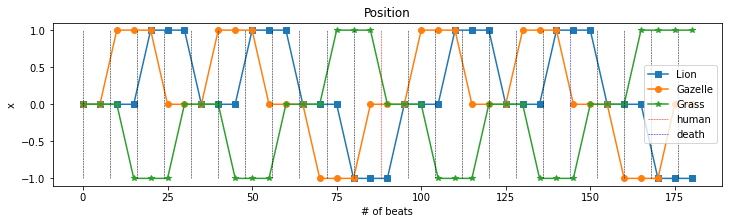

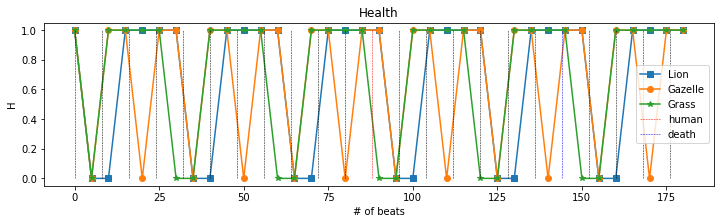

In [169]:
lion    = Animal(0, 2)
gazelle = Animal(0, 0)
grass   = Animal(0, 1)

real_engine = Engine([lion, gazelle, grass])
[t, carnivore, herbivore, plant] = real_engine.run()

showone(t, carnivore, herbivore, plant)
showone(t, carnivore, herbivore, plant, 1, 'Health', 'H',0)

## Used graph

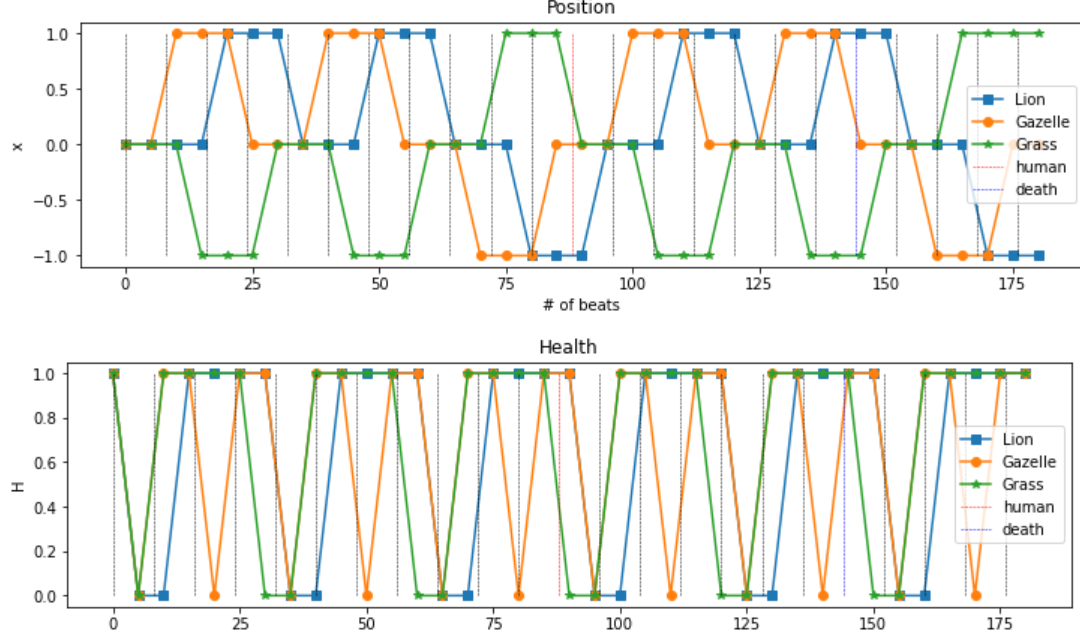

In [21]:
from IPython import display
display.Image("./Good graph.png")

We based ourself on this graph to implement the displacement and the health of the animals. The agitation has peaks at the moment where health changes, and in the second part is gradually increasing (human influence).

## Sequencer

We used a midi sequencer to combine in one temporal axis the chord progression with the evolution of all the species and to represent the parameters in a a format(midi) that could be routed to the granulator patch in order to manipulate the sounds. Therefore, each mass corresponds to one channel containing: 
- midi notes
- agitation envelope (violet)
- position envelope (purple)
- health envelope (cyan)


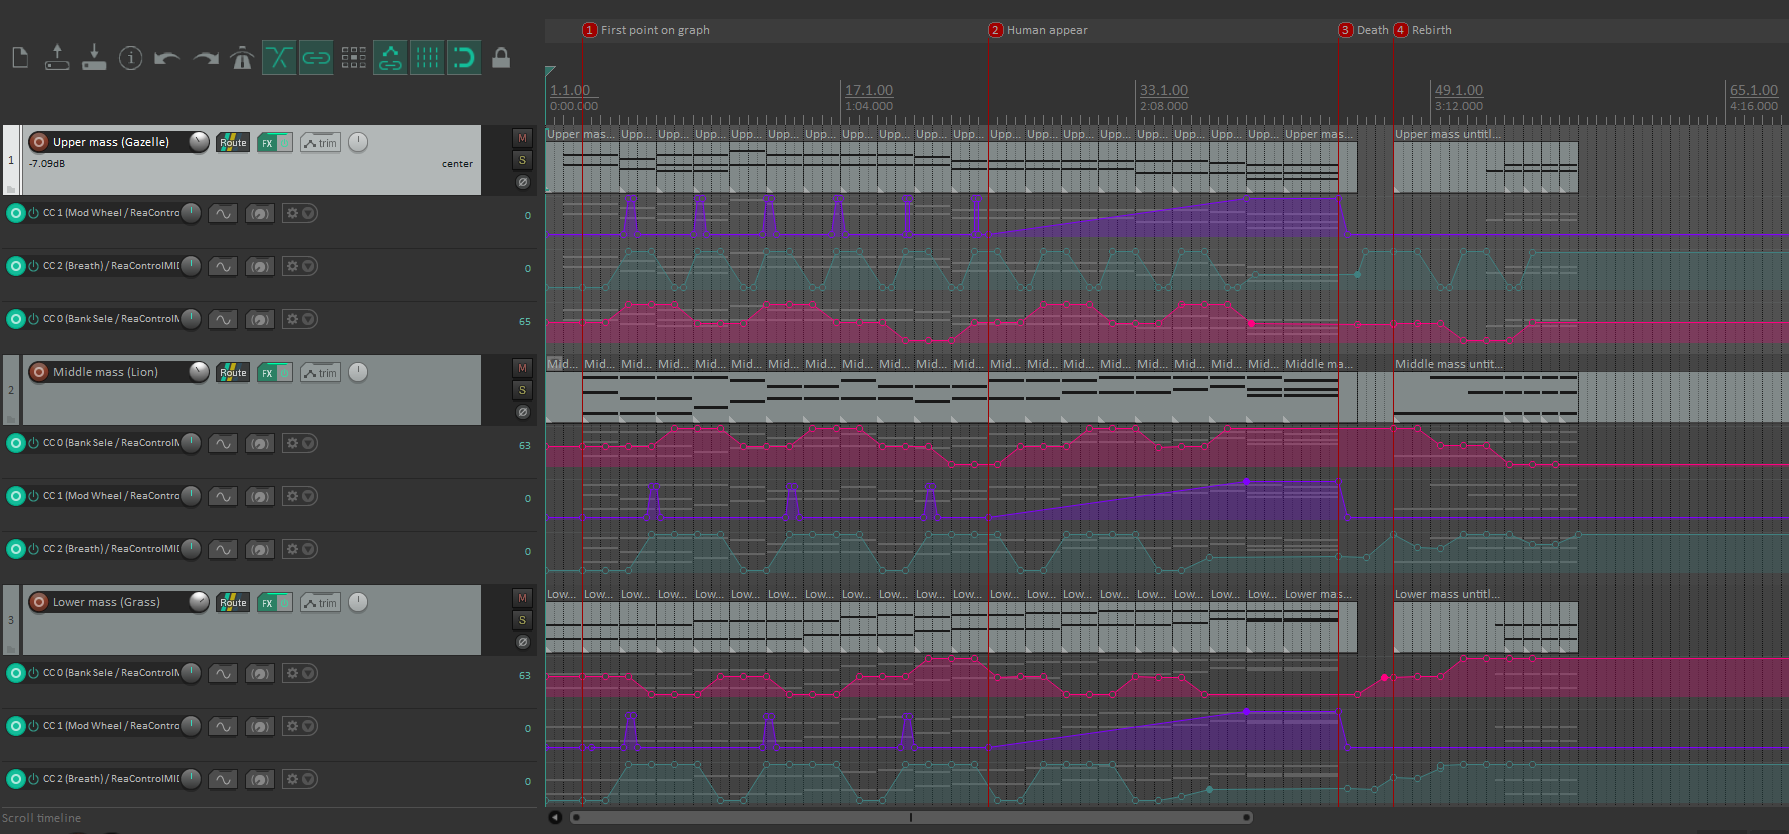

## Granular synthesis


We implemented a patch using VCV Rack. It consists of 3 different channels, one per species. 
Each species is constructed with the following procedure. 
- 3 combined oscillators/1 polyphonic oscillator are used together with an envelope editor to generate the original sound, characteristic of each species.
- The oscillator signal is passed through some filter, in order to select the desired frequency range and width.
- The sound coming from the filter is finally sent into the granulator and then to the mix master.

As explained in the essay, the sound parameters are automatized. The midi-cv module receives midi messages from a sequencer (Reaper) containing the chord progression and sends them to the oscillators, while the midi-cc module receives from Reaper the envelope of the position, health and agitation parameters over time. The micromap module is used when necessary to rescale the numbers coming from Reaper in order to make them fit into the correct range supported by each module control.
More specifically, the automatized knobs are:
- Position: panning, in the mix master module.
- Health: size and texture(= window shape) of the granulator module.
- Agitation: cutoff frequency of the filter and the cyan blend knob(=feedback) of the granulator.

The oscilloscopes visualization is constructed rescaling the output of the midi values coming from the midi-cc module and sending them as input for the JW Full scope module, in order to alter the color, size and displacement of the visualization.



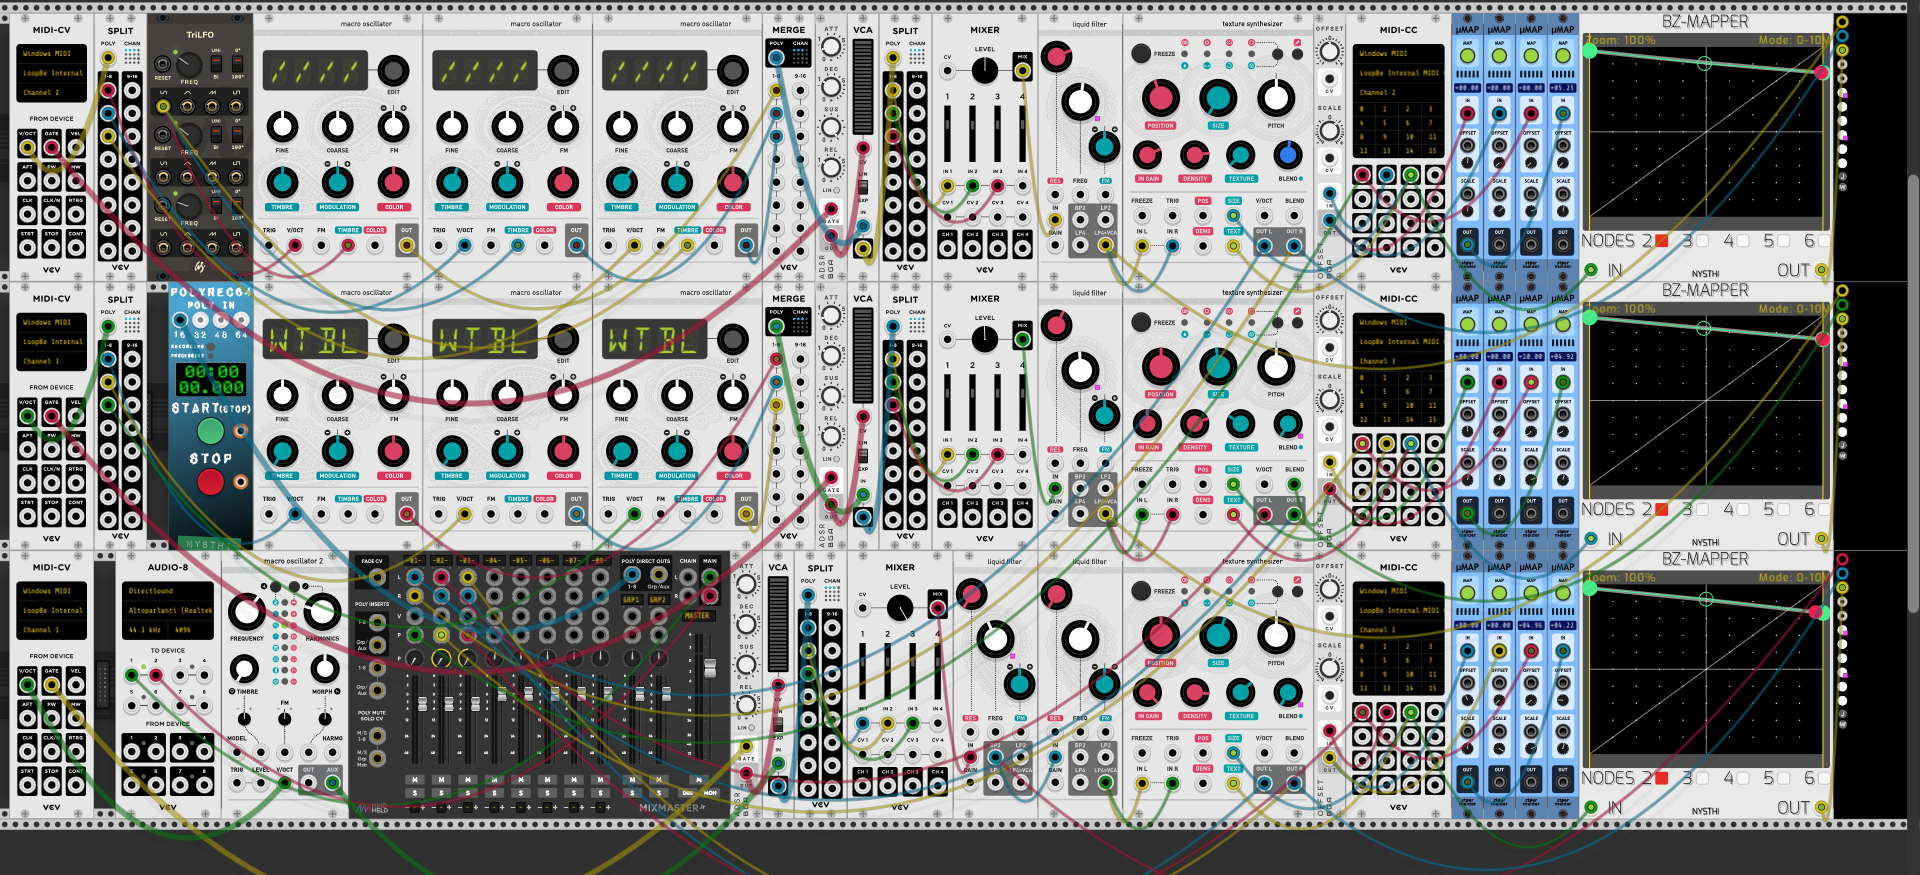